In [4]:
import numpy as np
import pandas as pd
import pickle, csv
import os

from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, Dropout, Input, concatenate, Flatten, Reshape
from keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow.keras.backend as K
from skimage.transform import resize

from matplotlib import pyplot as plt
from matplotlib import style
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

2023-04-20 14:03:46.603632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Load powerprice data and format it
df_powerprice = pd.read_csv("data/PowerPrice.csv")
df_powerprice["Time"] = pd.to_datetime(df_powerprice["Time"], infer_datetime_format=True)
df_powerprice = df_powerprice.drop(columns=["Time"])

In [6]:
# Load spatial data and format it
datasets = []
for filename in os.listdir("data/Spatial"):
    if filename.endswith(".pickle"):
        with open(os.path.join("data/Spatial", filename), "rb") as file:
            data = pickle.load(file)
            if data.shape == (100, 35040):
                datasets.append(data)
            else:
                print(f"Skipping {filename}: unexpected shape {data.shape}")

In [22]:
# Convert the list of arrays to a 3D array
spatial_data = np.stack(datasets, axis=0)

spatial_data = spatial_data.reshape((spatial_data.shape[0], spatial_data.shape[1], spatial_data.shape[2]))

# transpose the second and third dimensions to get shape (13, 35040, 100)
spatial_data = spatial_data.transpose((0, 1, 2))

spatial_data.shape

(13, 100, 35040)

In [25]:
# Load mask and reshape to match desired output shape
mask = pd.read_csv("germany/mask.csv", header=None).values
#mask = mask_df.values.reshape((40, 40, 1))

#mask.shape

In [27]:
spatial_data.shape

(13, 100, 35040)

In [40]:
image_all = np.zeros((35040, 40, 40, 13))
for j in range(spatial_data.shape[2]):
    for i in range(spatial_data.shape[0]):
        image = np.zeros((40, 40))
        for s in range(spatial_data.shape[1]):
            image[mask == s] = spatial_data[i,s,j]
        #print(i)
        image_all[j, :, :, i] = image

In [41]:
spatial_data = spatial_data.repeat(16, axis=2) # Repeat each spatial map 16 times
spatial_data = spatial_data.transpose((0, 2, 1)) # Transpose to (13, 35040, 100)
spatial_data = spatial_data.reshape((spatial_data.shape[0], 40, 40, -1)) # Reshape to (13, 40, 40, 35040)
spatial_data.shape

(13, 40, 40, 35040)

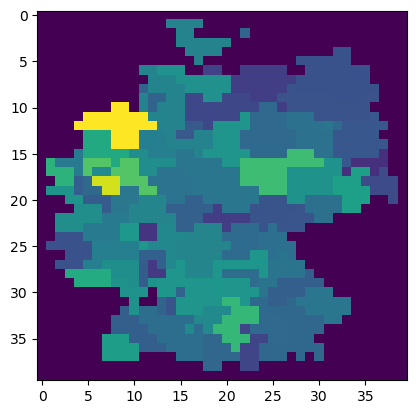

In [44]:
plt.imshow(image_all[4,:,:,7])
plt.show()

In [45]:
image_all.shape

(35040, 40, 40, 13)

In [ ]:
(35040, 6, 40, 40, 13)

In [ ]:
(32, 6, 40, 40, 13)

In [ ]:
(32*6, 40, 40, 13)

In [ ]:
CNN

In [ ]:
(32*6, 4, 4, 32)

In [ ]:
Reshape

In [ ]:
(32*6, 4*4*32)

In [ ]:
FNN

In [ ]:
(32*6, 1)

In [ ]:
Reshape

In [ ]:
(32, 6, 1)

In [10]:
# Tile the mask to have the same shape as spatial_data
mask_data = np.tile(mask, (spatial_data.shape[0], 1, 1, 0))
mask_data.shape

(13, 40, 40, 0)

In [11]:
print("Spatial data shape: ", spatial_data.shape)
print("Mask data shape: ", mask_data.shape)

Spatial data shape:  (13, 40, 40, 35040)
Mask data shape:  (13, 40, 40, 0)


In [12]:
# Concatenate spatial data (13, 40, 40, 35040) and mask data (13, 40, 40, 0)
df = np.concatenate([spatial_data, mask_data], axis=3)
df.shape

(13, 40, 40, 35040)

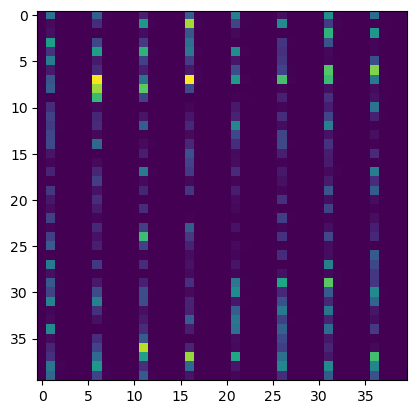

In [13]:
import matplotlib.pyplot as plt
plt.imshow(df[1,:,:,0])
plt.show()

the input shape is (35040, 40, 40, 13) that there are 35040 images with dimensions 40x40 and 13 channels.

In [763]:
# transpose to get shape (35040, 40, 40, 13)
df = df.transpose((3, 1, 2, 0))
df.shape

(35040, 40, 40, 13)

In [764]:
# time series data with window of size 6
window_size = 6
X = []
y = []
for i in range(window_size, 35034):
    # window
    window = df[i-window_size:i, :, :, :]
    X.append(window.transpose((0, 1, 2, 3)))
    # label
    label = df[i, :, :, :]
    # Transpose label to shape (13, 40, 40)
    label = label.transpose((1, 0, 2))
    y.append(label)
# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

In [765]:
print(f"X shape : {X.shape}")
print(f"y shape : {y.shape}")

X shape : (35028, 6, 40, 40, 13)
y shape : (35028, 40, 40, 13)


In [766]:
# Define the train, validation, and test set sizes
train_size = int(0.6 * len(X))
val_size = int(0.2 * len(X))
test_size = len(X) - train_size - val_size

# Split the data into train, validation, and test sets
X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]
X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

In [767]:
print("Train set shape:", X_train.shape, y_train.shape) 
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (21016, 6, 40, 40, 13) (21016, 40, 40, 13)
Validation set shape: (7005, 6, 40, 40, 13) (7005, 40, 40, 13)
Test set shape: (7007, 6, 40, 40, 13) (7007, 40, 40, 13)


In [769]:
df_input = Input(shape=(40, 40, 13))
conv_layer = Conv2D(32, kernel_size=(3,3), activation="relu")(df_input)
conv_layer = MaxPooling2D(pool_size=(2, 2))(conv_layer)
conv_layer = Conv2D(64, kernel_size=(3, 3), activation="relu")(conv_layer)
conv_layer = MaxPooling2D(pool_size=(2, 2))(conv_layer)
flatten_layer = Flatten()(conv_layer)
fcnn_layer = Dense(64, activation="relu")(flatten_layer)
fcnn_layer = Dropout(0.2)(fcnn_layer)
fcnn_layer = Dense(32, activation="relu")(fcnn_layer)
fcnn_layer = Dropout(0.2)(fcnn_layer)
fcnn_output = Dense(10, activation="relu")(fcnn_layer)

fcnn_output.shape

TensorShape([None, 10])

In [770]:
model = Model(inputs=df_input, outputs=fcnn_output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 40, 40, 13)]      0         
                                                                 
 conv2d_15 (Conv2D)          (None, 38, 38, 32)        3776      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 19, 19, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 17, 17, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 4096)              0   

In [771]:
# Compile the model with optimizer and loss function
model.compile(optimizer='adam', loss='mse')

# Fit the model on the training data
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10


ValueError: in user code:

    File "C:\Users\113202010\Anaconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\113202010\Anaconda3\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\113202010\Anaconda3\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\113202010\Anaconda3\lib\site-packages\keras\engine\training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\113202010\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\113202010\Anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 40, 40, 13), found shape=(None, 6, 40, 40, 13)
